<a href="https://colab.research.google.com/github/Naidala/CNN_medical_imaging/blob/main/DataAugmentationFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from google.colab import drive
import os
import copy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [ ]:
EPOCHS = 75
INIT_LR = 1e-3
BS = 64
IMAGE_DIMS = (150, 150, 1)

In [ ]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense

def model_old(dropout):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  if dropout is not 0:
    model.add(Dropout(dropout))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  return model

In [ ]:
def plot_acc_loss(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()


def best_epoch(history):      # to see when validation stop to get any better
  x = history.history['val_loss']
  k = 3
  trend = []
  stop = 0
  for i in range(k,len(x)-k):
    if stop == 0:
      num = 0
      for j in range(-k, k+1):
        num = x[i+j] + num
      if len(trend) == 0:
        trend.append(num/(2*k+1))
      elif num/(2*k+1) <= trend[len(trend)-1] + 0.005:
        trend.append(num/(2*k+1))
      else:
        stop = 1
  print(2*k+len(trend))

## Variable formulation
We remove the healthy tissue images and give the tensors the form (2676, 150, 150, 1), and rescale the RGB pixel values (0 to 65535) so that they are between 0 and 1. We also declare a new variable for training and validation to be used when augmentation and pre-training come into play.
We note that Assignment instructions do not copy objects, but create links between a target and an object. We use deepcopy because we want a new variable to modify without automatically modifying the original at the same time.

In [ ]:
drive.mount('/content/drive/')
out_path = "/content/drive/My Drive/CompIntProjects_Paiano/FinalProject2019/numpy data/"

def load_data():
  train_images = np.load(os.path.join(out_path,'train_tensor.npy'))
  train_labels = np.load(os.path.join(out_path,'train_labels.npy'))
  test_images = np.load(os.path.join(out_path,'public_test_tensor.npy'))
  test_labels = np.load(os.path.join(out_path,'public_test_labels.npy'))
  train_images = train_images.astype('float32') / 65535   #BW 16-bit, normalization
  train_images = train_images.reshape((len(train_images), 150, 150, 1))
  test_images = test_images.astype('float32') / 65535
  test_images = test_images.reshape((len(test_images), 150, 150, 1))
  return train_images, train_labels, test_images, test_labels


def abnormal_variables():   # remove healthy patch
  train_images, train_labels, test_images, test_labels = load_data()
  train_images = train_images[1:len(train_images):2]
  train_labels = train_labels[1:len(train_labels):2]
  test_images = test_images[1:len(test_images):2]
  test_labels = test_labels[1:len(test_labels):2]
  return train_images, train_labels, test_images, test_labels


def augment(train_images, train_labels):
  np.random.seed(5)
  np.random.shuffle(train_images)
  np.random.seed(5)
  np.random.shuffle(train_labels)
  PERCENTAGE_VALIDATION = 0.2
  num_validation_samples = round(len(train_labels)*PERCENTAGE_VALIDATION)
  my_val_images = copy.deepcopy(train_images[:num_validation_samples])
  my_val_labels = copy.deepcopy(train_labels[:num_validation_samples])
  my_train_images = copy.deepcopy(train_images[num_validation_samples:])
  my_train_labels = copy.deepcopy(train_labels[num_validation_samples:])
  return my_train_images, my_train_labels, my_val_images, my_val_labels

# **Two-class Classification**
(Mass or Calcification)

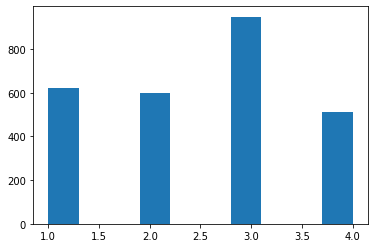

In [ ]:
# we divide in two groups: mass (0) and calcification (1)
def labels_in_two(labels):
  for i in range(0,len(labels)):
    if labels[i] > 0 and labels[i] < 3 :
      labels[i] = 0
    else :
      labels[i] = 1

train_images_2, train_labels_2, test_images_2, test_labels_2 = abnormal_variables()
plt.hist(train_labels_2)    # we show samples distribution
plt.show()

labels_in_two(train_labels_2)
labels_in_two(test_labels_2)

## WITHOUT AUGMENTATION

In [ ]:
# BUILDING THE MODEL

model = model_old(0)
#opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
opt = Adam(lr=INIT_LR)
model.compile(loss = 'binary_crossentropy',
              optimizer = opt,
              metrics = ['acc'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
EPOCH = 35
history = model.fit(train_images_2,
                      train_labels_2,
                      epochs = EPOCH,
                      batch_size = BS,
                      validation_split = 0.2,
                      shuffle = True)

In [ ]:
test_loss, test_acc = model.evaluate(test_images_2, test_labels_2)
print('test_acc: ', test_acc)

336/336 [==============================] - 0s 1ms/step
test_acc:  0.8095238208770752


In [ ]:
#save_dir = "/content/drive/My Drive/CompIntProjects/2classes"
#if not os.path.exists(save_dir):
#  os.makedirs(save_dir)
#model.save(os.path.join(save_dir,'2classes_scratch.h5'))

20


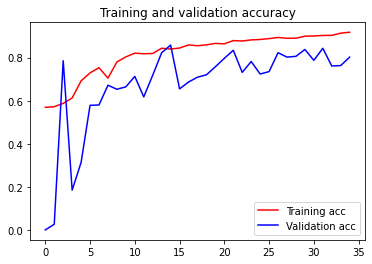

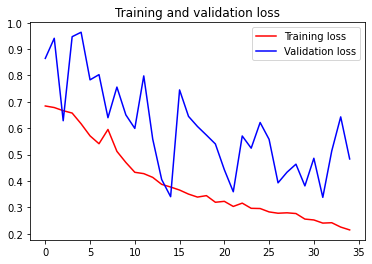

In [ ]:
best_epoch(history)
plot_acc_loss(history)

## WITH AUGMENTATION

In [ ]:
my_train_images, my_train_labels, my_val_images, my_val_labels = augment(train_images_2,train_labels_2)

aug2 = ImageDataGenerator(rotation_range = 20,
                          shear_range = 0.3,
                          zoom_range = 0.5,
                          height_shift_range = 0.1,
                          width_shift_range = 0.1,
                          horizontal_flip = True,
                          vertical_flip = True,
                          fill_mode = 'nearest')

In [ ]:
model = model_old(0.5)
EPOCH_AUG_2 = 100

#opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCH_AUG_2)
opt = Adam(lr=INIT_LR)
model.compile(loss='binary_crossentropy',
              optimizer = opt,
              metrics=['acc'])

# This time we won't have "validation split", as in "fit": that's why
# we had "manually" mixed up samples and kept aside a validation set
history = model.fit_generator(
      aug2.flow(my_train_images,my_train_labels,batch_size = BS),
      validation_data = (my_val_images,my_val_labels),
      steps_per_epoch = len(my_train_labels) // BS,
      epochs = EPOCH_AUG_2)

In [ ]:
test_loss, test_acc = model.evaluate(test_images_2, test_labels_2)
print('test_acc: ', test_acc)

336/336 [==============================] - 0s 552us/step
test_acc:  0.875


52


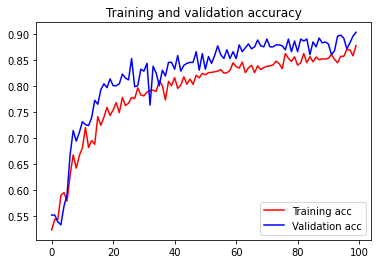

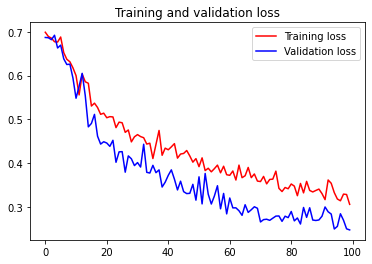

In [ ]:
best_epoch(history)
plot_acc_loss(history)

In [ ]:
#save_dir = "/content/drive/My Drive/CompIntProjects/2classes"
#if not os.path.exists(save_dir):
#  os.makedirs(save_dir)
#model.save(os.path.join(save_dir,'2classes_aug.h5'))

# **Four-Class Classification (w/ augmentation)**
(malignant masses, benign masses, malignant calcification and benign calcification)

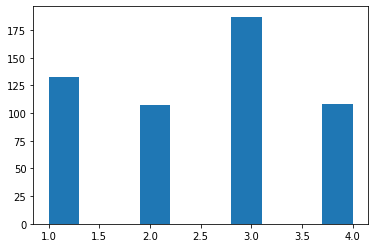

In [ ]:
from tensorflow.keras.utils import to_categorical
# We will use categorical instead of binary since classes are four, not two:
# since to_categorical wants integers from 0 to num_classes - 1, we'll fix that
def labels_in_four(labels):
  for i in range(0,len(labels)):
    labels[i] = labels[i] - 1
  return to_categorical(labels, num_classes = 4)


train_images_4, train_labels_4, test_images_4, test_labels_4 = abnormal_variables()
my_train_images_4, my_train_labels_4, my_val_images_4, my_val_labels_4 = augment(train_images_4, train_labels_4)
plt.hist(my_val_labels_4)       # we show augmented distribution mimic the real one
plt.show()
my_train_labels_4 = labels_in_four(my_train_labels_4)
my_val_labels_4 = labels_in_four(my_val_labels_4)
test_labels_4 = labels_in_four(test_labels_4)


aug4 = ImageDataGenerator(rotation_range = 20,
                          shear_range = 0.3,
                          zoom_range = 0.5,
                          height_shift_range = 0.1,
                          width_shift_range = 0.1,
                          horizontal_flip = True,
                          vertical_flip = True,
                          fill_mode = 'nearest')

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.6))
model.add(layers.Dense(173, activation='relu'))
#model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='sigmoid'))

model.compile(loss = 'categorical_crossentropy',
               optimizer = optimizers.Adam(lr = 0.0001),
               metrics = ['acc'])

In [ ]:
EPOCH_AUG_4 = 75
history = model.fit_generator(
      aug4.flow(my_train_images_4,my_train_labels_4,batch_size = BS),
      validation_data = (my_val_images_4,my_val_labels_4),
      steps_per_epoch = len(my_train_labels_4) // BS,
      epochs = EPOCH_AUG_4,
      validation_steps = len(my_val_labels_4) // BS,
      shuffle = True)

In [ ]:
test_loss, test_acc = model.evaluate(test_images_4, test_labels_4)
print('test_acc: ', test_acc)
best_epoch(history)
plot_acc_loss(history)

In [ ]:
#save_dir = "/content/drive/My Drive/CompIntProjects/4classes"
#if not os.path.exists(save_dir):
#  os.makedirs(save_dir)
#model.save(os.path.join(save_dir,'4classes_aug.h5'))